# This notebook lays out the process of importing lightcurve data and (using an MCMC) fitting a transit model to that data, given a set of planet parameters.

A more complete and self-contained version of this TFOP pipeline will soon be available on [the author's github](https://github.com/waalkesw).

**Authors: [Will Waalkes](https://www.colorado.edu/aps/will-waalkes), [Zach Berta-Thompson](http://casa.colorado.edu/~bertathompson/)**

In [1]:
%matplotlib inline
import lightkurve as lk
import pandas
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table, Column
import lightkurve
import emcee
from lightkurve.lightcurve import LightCurve
from astropy.modeling import models, fitting, optimizers, statistic, custom_model
import batman
from ldtk import (LDPSetCreator,BoxcarFilter)
from ldtk.filters import kepler
import corner as triangle
import astropy.constants as c
import astropy.units as u

In [2]:
def Limb_Dark(Teff = 3300,
              Terr = 100,
              log_g = 4.90,
              g_err = 0.2,
              met = 0.0,
              met_err = 0.01,
              filters = [kepler]):
        
    sc = LDPSetCreator(filters=filters,
                   teff=[Teff,Terr],
                   logg=[log_g, g_err],
                   z=[met, met_err],force_download=False)
    
    ps = sc.create_profiles(nsamples=5000)
    qc,qe = ps.coeffs_qd(do_mc=True)
    
    return qc,qe

In [3]:
def BATMAN(P,
           Rp,
           t0,
           inc,
           A,
           LD,
           t = None,
           Baseline = 1.0):
                    
    params = batman.TransitParams()
    params.t0 = t0                       # time of inferior conjunction ()
    params.per = P                       # period in hours
    params.rp = Rp                       # planet radius (in units of stellar radii)
    params.a = A                         # semi-major axis (in units of stellar radii)
    params.inc = inc                     # orbital inclination (in degrees)
    params.ecc = 0.                      # eccentricity
    params.w = 90.                       # longitude of periastron (in degrees)
    params.u = LD                        # limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       # limb darkening model
        
    #m = batman.TransitModel(params, t, exp_time=60.0, supersample_factor = 12)   # initializes model
    m = batman.TransitModel(params, t)   # initializes model
    
    flux = m.light_curve(params)*Baseline   # calculates light curve
    
    return flux

In [4]:
def lnprior(LC1,LC2,LC3,LC4,LC5,LC6,
            theta,
            planet_a):
    
    A1,A2,A3,A4,A5,A6,B1,B2,B3,B4,B5,B6,t1,t2,t3,t5,t6,rp,a,i = theta
        
    i_min = np.arccos(1/a)*180/np.pi

    if (0.0 <= rp <= 1.0) and (0.5*planet_a <= a <= planet_a + 20 ) and (i <= 90.0):
        
        return 0.0
    
    return -np.inf

In [5]:
def lnprob(theta,
           LC1,LC2,LC3,LC4,LC5,LC6,
           planet_period,
           LD1,LD2,LD3,LD4,LD5,LD6,
           airmass1,
           airmass2,
           airmass3,
           airmass4,
           airmass5,
           airmass6,
           planet_a,
           plot = False):
        
    # Pull out some model parameters
    A1,A2,A3,A4,A5,A6,B1,B2,B3,B4,B5,B6,t1,t2,t3,t5,t6,rp,a,i = theta    
    
    # First we want a model to perform the lnprob calculation with.
    model1 = (A1 + B1*(airmass1-1))*BATMAN(planet_period, rp, t1, i, a, LD1, t = LC1.time)
    model2 = (A2 + B2*(airmass2-1))*BATMAN(planet_period, rp, t2, i, a, LD2, t = LC2.time)
    model3 = (A3 + B3*(airmass3-1))*BATMAN(planet_period, rp, t3, i, a, LD3, t = LC3.time)
    model4 = (A4 + B4*(airmass4-1))*BATMAN(planet_period, rp, t2, i, a, LD4, t = LC4.time)
    model5 = (A5 + B5*(airmass5-1))*BATMAN(planet_period, rp, t5, i, a, LD5, t = LC5.time)
    model6 = (A6 + B6*(airmass6-1))*BATMAN(planet_period, rp, t6, i, a, LD6, t = LC6.time)
        
    # We need to make sure the uniform priors are accounted for:
    ln_prior = lnprior(LC1,LC2,LC3,LC4,LC5,LC6, theta, planet_a)
    
    # This is a Gaussian likelihood, for independent data points
    
    chisq1 = np.sum((LC1.flux - model1)**2/(LC1.flux_err)**2)
    ln_like1 = (np.sum(1/np.sqrt(2*np.pi*(LC1.flux_err))) - 0.5*chisq1)
    
    chisq2 = np.sum((LC2.flux - model2)**2/(LC2.flux_err)**2)
    ln_like2 = (np.sum(1/np.sqrt(2*np.pi*(LC2.flux_err))) - 0.5*chisq2)
    
    chisq3 = np.sum((LC3.flux - model3)**2/(LC3.flux_err)**2)
    ln_like3 = (np.sum(1/np.sqrt(2*np.pi*(LC3.flux_err))) - 0.5*chisq3)
    
    chisq4 = np.sum((LC4.flux - model4)**2/(LC4.flux_err)**2)
    ln_like4 = (np.sum(1/np.sqrt(2*np.pi*(LC4.flux_err))) - 0.5*chisq4)
    
    chisq5 = np.sum((LC5.flux - model5)**2/(LC5.flux_err)**2)
    ln_like5 = (np.sum(1/np.sqrt(2*np.pi*(LC5.flux_err))) - 0.5*chisq5)
    
    chisq6 = np.sum((LC6.flux - model6)**2/(LC6.flux_err)**2)
    ln_like6 = (np.sum(1/np.sqrt(2*np.pi*(LC6.flux_err))) - 0.5*chisq6)
    
    return ln_prior+ln_like1+ln_like2+ln_like3+ln_like4+ln_like5+ln_like6

In [6]:
def corner(samples_LCO,samples_TESS):
        
    labels = ['Rp/R*','a/R*','i (deg)']
    Samples_LCO = samples_LCO[-3:].T
    Samples_TESS = samples_TESS[-3:].T
    
    np.random.seed(23)  
    
    figure1 = triangle.corner(Samples_LCO,labels=labels,quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},color='red',alpha=1.0,
                            plot_contours=True,zorder=1000,plot_datapoints=False)
    figure1.suptitle("Samples from fitting the TESS data (black) and the LCO data (red)",y=1.04,size=20)
    
    triangle.corner(Samples_TESS,labels=labels,color='black',alpha=0.1,
                     fig=figure1,zorder=-100,plot_contours=True,marker='o',plot_datapoints=False)      
    
    plt.tight_layout()
    plt.savefig('TOI_{:.0f}_Corner.pdf'.format(toi))

In [7]:
def light_curve(lc,
                best_parameters,
                sampler,
                static_params,
                nsteps,
                epoch,
                tic_id,
                obs='first'):
    
    ########################
    # Read in the parameters
    ########################
    
    planet_radius, planet_period, planet_a, planet_i, toi = static_params
    hires_times = np.linspace(lc.time[0]-1,lc.time[-1]+1,1000)
    C1_best, C2_best, rp_best, t_0_best, a_best, i_best = best_parameters
    burnin = int(0.25*nsteps)
    
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,A6_sam,B1_sam,B2_sam,B3_sam,B4_sam,B5_sam,B6_sam,t01_sam,t02_sam,t03_sam,t05_sam,t06_sam,Rp,A,Inc = samples
    
    if obs == 'first':
        C1 = A1_sam
        C2 = B1_sam
        t0 = t01_sam
        airmass = airmass1
        offset = offset1
        obs_title = 'LCO-CTIO 2019-06-14 I-band'
        LD = LD1
        observatory = 'LCO'
        
    if obs == 'second':
        C1 = A2_sam
        C2 = B2_sam
        t0 = t02_sam
        airmass = airmass2
        offset = offset2
        obs_title = 'LCO-CTIO 2019-08-02 I-band'
        LD = LD1
        observatory = 'LCO'
        
    if obs == 'third':
        C1 = A3_sam
        C2 = B3_sam
        t0 = t03_sam
        airmass = airmass3
        offset = offset3
        obs_title = 'TRAPPIST-South 2019-06-02 I&z-bands'
        LD = LD3
        observatory = 'TRAPPIST-South'
        
    if obs == 'fourth':
        C1 = A4_sam
        C2 = B4_sam
        t0 = t02_sam
        airmass = airmass4
        offset = offset4
        obs_title = 'LCO-CTIO 2019-08-02 g\'-band'
        LD = LD4
        observatory = 'LCO'
        
    if obs == 'fifth':
        C1 = A5_sam
        C2 = B5_sam
        t0 = t05_sam
        airmass = airmass5
        offset = offset5
        obs_title = 'LCO-SAAO 2019-08-13 I-band'
        LD = LD1
        observatory = 'LCO'
        
    if obs == 'sixth':
        C1 = A6_sam
        C2 = B6_sam
        t0 = t06_sam
        airmass = airmass6
        offset = offset6
        obs_title = 'LCO-SAAO 2019-09-03 I-band'
        LD = LD1
        observatory = 'LCO'
    
    ########################################################################
    # Calculate the model with the best-fit MCMC params, calculate residuals
    ########################################################################
    
    model_to_plot = BATMAN(planet_period, rp_best, t_0_best, i_best, a_best, LD, t = hires_times)
    best_model = (C1_best + C2_best*(airmass-1))*BATMAN(planet_period, rp_best, t_0_best,
                                                        i_best, a_best, LD, t = lc.time)
    residual = (lc.flux-best_model)/lc.flux_err
    
    #########################
    # Plot the best-fit model
    #########################
            
    f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[4,1]},
                               figsize=(10,7),sharex=True)
    
    a0.set_title('{}'.format(obs_title),fontsize=20)
    a0.errorbar((lc.time-t_0_best)*24,lc.flux/(C1_best + C2_best*(airmass-1)),
                yerr=lc.flux_err/(C1_best + C2_best*(airmass-1)),
                fmt='o',alpha=0.5,color='royalblue',markersize='5',
                label=observatory+' data')
    a0.plot((hires_times-t_0_best)*24,model_to_plot,label='Best-Fit Model',color='k',zorder=100)
    a0.set_ylabel('Normalized Flux',fontsize=18)
    a0.set_xlim(-2.5,2.5)
    a0.set_ylim(0.985,1.01)
    a0.minorticks_on()
    a0.legend(loc='lower right')
    a0.tick_params(labelbottom=False, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
    
    #########################################
    # Plot 200 random models from the samples
    #########################################
    
    for j in range(0,200,1):
        i = np.random.randint(low=0,high=(nsteps-burnin)*nwalkers)
        sigma_model = BATMAN(P = planet_period, Rp = Rp[i], t0 = t0[i],
                             inc = Inc[i], A = A[i], LD = LD, t = hires_times)
        a0.plot((hires_times-t_0_best)*24,sigma_model,color='red',alpha = 0.1,
                linewidth=0.8,zorder=-1000,label='Random Samples')
        
    ####################
    # Plot the residuals
    ####################

    a1.scatter((lc.time-t_0_best)*24,residual,color='royalblue',alpha=0.5)
    a1.axhline(0,color='k')
    a1.set_ylim(0-1.5*np.max(np.abs(residual)),0+1.5*np.max(np.abs(residual)))
    a1.minorticks_on()
    a1.set_ylabel(r'Residuals ($\rm{\sigma}$)',fontsize=15)
    a1.set_xlabel('Time from Mid-Transit (hr)',fontsize=16)
    a1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False,
                   bottom=True, top=True, left=True, right=True)
        
    plt.savefig('TOI_{:.0f}_modeled'.format(toi)+obs+'.pdf')

In [8]:
params = pandas.read_csv('TESS_Objects.csv',comment='#')

TIC_ID = params['TIC ID']
TOI = params['TOI']

In [11]:
index = int(170)

tic_id = int(TIC_ID[index])
toi = TOI[index]
observatory = 'LCO 1-m'
print('TIC {:.0f}'.format(tic_id))
print('TOI {:.2f}'.format(toi))

TIC 305048087
TOI 237.01


In [12]:
planet_period = params['P (days)'][index] # must be in days
planet_radius = params['Rp/R*'][index] # Rp/R*
Epoch = params['Epoch'][index] 
epoch = Epoch + 2457000.0
planet_a = params['a/R*'][index] # a/R*
planet_b = params['b'][index] # impact parameter
planet_duration = params['Dur'][index] #hours
ppm_depth = params['Depth'][index] #ppm

planet_i = np.arccos(planet_b/planet_a)*180/np.pi #inclination in degrees
depth = 1.0-ppm_depth/1e6

star_teff = params['T_eff'][index] # K
star_met = params['Met'][index] # metallicity
star_g = params['logg'][index] # log g
star_radius = params['R_s'][index] #R*/Rsun
star_mass = params['M_s'][index]

Need to download 51 files, approximately 17.03 MB



[[0.2656534  0.29114157]] [[0.01001187 0.02052186]]
Anticipated mid-transit time = 0.799102


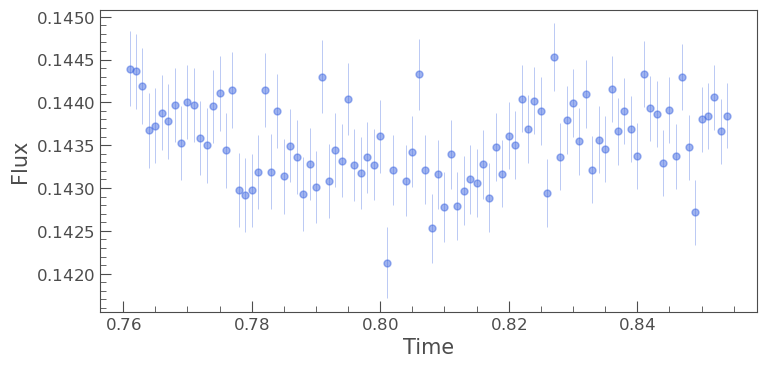

In [13]:
data1 = pandas.read_csv('TOI_237/TIC_305048087_Data1.csv')
flux1 = np.array(data1['rel_flux_T1'])
error1 = np.array(data1['rel_flux_err_T1'])*1.24
times1 = np.array(data1['BJD-OBS'])
airmass1 = np.array(data1['AIRMASS'])
exptime_s1 = np.median(data1['EXPTIME'])
exptime_d1 = exptime_s1 * (1/60) * (1/60) * (1/24)
offset1 = int(times1[0])
times1 = times1-offset1

LC1 = LightCurve(time = times1, flux = flux1, flux_err = error1).remove_outliers(sigma=8)
A1 = np.median(LC1.flux)
B1 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                                     filters=[BoxcarFilter('I',650,1050)])
LD1 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset1
for i in range(len(n)):
    if (mid_transit_times[i] >= LC1.time[0]):
        if (mid_transit_times[i] <= LC1.time[-1]):
            
            expected_t0_1 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_1))

LC1.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

Anticipated mid-transit time = 0.723984


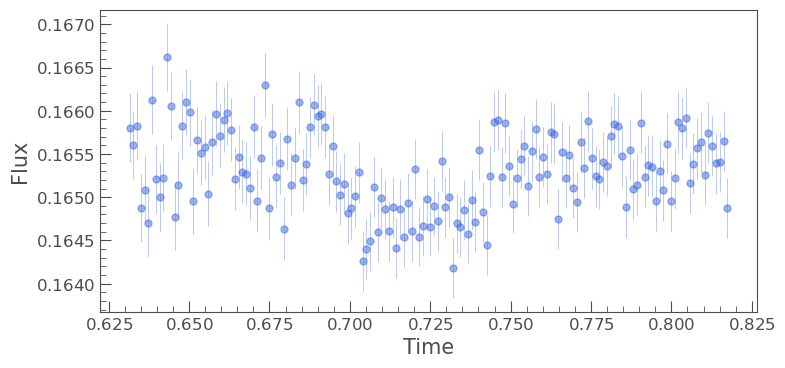

In [14]:
data2 = pandas.read_csv('TOI_237/TIC_305048087_Data3.csv')
flux2 = np.array(data2['rel_flux_T1'])
error2 = np.array(data2['rel_flux_err_T1'])*1.37
times2 = np.array(data2['BJD_TDB'])
airmass2 = np.array(data2['AIRMASS'])
exptime_s2 = np.median(data2['EXPTIME'])
exptime_d2 = exptime_s2 * (1/60) * (1/60) * (1/24)
offset2 = int(times2[0])
times2 = times2-offset2

LC2 = LightCurve(time = times2, flux = flux2, flux_err = error2).remove_outliers(sigma=8)
LC2.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A2 = np.median(LC2.flux)
B2 = 0.0

LD2 = LD1

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset2
for i in range(len(n)):
    if (mid_transit_times[i] >= LC2.time[0]):
        if (mid_transit_times[i] <= LC2.time[-1]):
            
            expected_t0_2 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_2))

[[0.29670381 0.33428848]] [[0.01375578 0.02596303]]
Anticipated mid-transit time = 0.926906


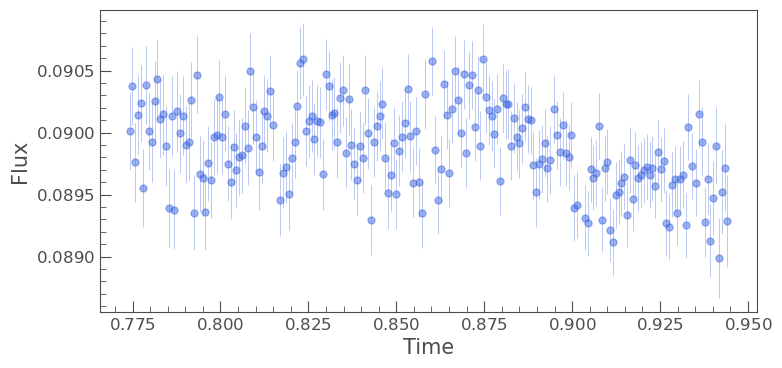

In [15]:
data3 = pandas.read_csv('TOI_237/TOI237_20190602_TRAPPIST-South_I+z.csv')
flux3 = np.array(data3['rel_flux_T1'])
error3 = np.array(data3['rel_flux_err_T1'])*0.98
times3 = np.array(data3['BJD_TDB'])
airmass3 = np.array(data3['AIRMASS'])
exptime_s3 = np.median(data3['EXPTIME'])
exptime_d3 = exptime_s3 * (1/60) * (1/60) * (1/24)
offset3 = int(times3[0])
times3 = times3-offset3

LC3 = LightCurve(time = times3, flux = flux3, flux_err = error3).remove_outliers(sigma=8)
LC3.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A3 = np.median(LC3.flux)
B3 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('I&z',710,900)])
LD3 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset3
for i in range(len(n)):
    if (mid_transit_times[i] >= LC3.time[0]):
        if (mid_transit_times[i] <= LC3.time[-1]):
            
            expected_t0_3 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_3))

[[0.57200476 0.29253449]] [[0.01907408 0.02957868]]


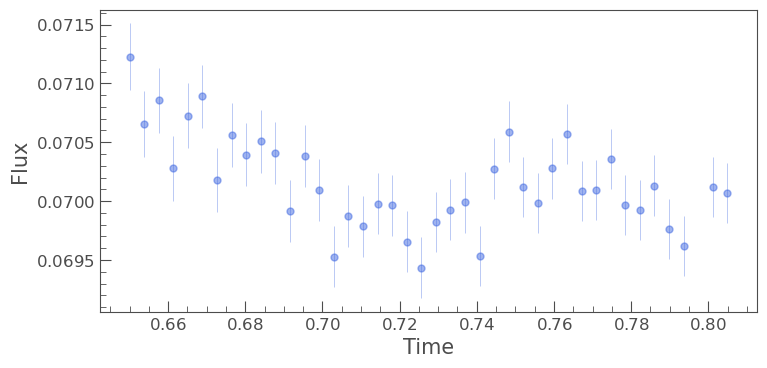

In [16]:
data4 = pandas.read_csv('TOI_237/TOI237_20190802_LCO-CTIO-1m_gp_measurements.csv')
flux4 = np.array(data4['rel_flux_T1'])
error4 = np.array(data4['rel_flux_err_T1'])*1.39
times4 = np.array(data4['BJD_TDB'])
airmass4 = np.array(data4['AIRMASS'])
exptime_s4 = np.median(data4['EXPTIME'])
exptime_d4 = exptime_s4 * (1/60) * (1/60) * (1/24)
offset4 = int(times4[0])
times4 = times4-offset4

LC4 = LightCurve(time = times4, flux = flux4, flux_err = error4).remove_outliers(sigma=8)
LC4.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A4 = np.median(LC4.flux)
B4 = 0.0

LD_coeff, LD_err = Limb_Dark(Teff = star_teff, log_g = star_g, met = star_met,
                             filters=[BoxcarFilter('gp',400,550)])
LD4 = [LD_coeff[0][0],LD_coeff[0][1]]
print(LD_coeff,LD_err)

expected_t0_4 = expected_t0_2

Anticipated mid-transit time = 0.596180


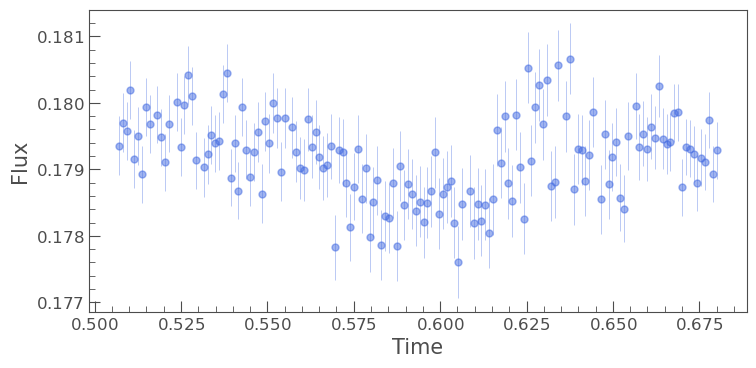

In [17]:
data5 = pandas.read_csv('TOI_237/TIC_305048087_Data4.csv')
flux5 = np.array(data5['rel_flux_T1'])
error5 = np.array(data5['rel_flux_err_T1'])*1.17
times5 = np.array(data5['BJD_TDB'])
airmass5 = np.array(data5['AIRMASS'])
exptime_s5 = np.median(data5['EXPTIME'])
exptime_d5 = exptime_s5 * (1/60) * (1/60) * (1/24)
offset5 = int(times5[0])
times5 = times5-offset5

LC5 = LightCurve(time = times5, flux = flux5, flux_err = error5).remove_outliers(sigma=8)
LC5.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A5 = np.median(LC5.flux)
B5 = 0.0

LD5 = LD1

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset5
for i in range(len(n)):
    if (mid_transit_times[i] >= LC5.time[0]):
        if (mid_transit_times[i] <= LC5.time[-1]):
            
            expected_t0_5 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_5))

Anticipated mid-transit time = 0.340572


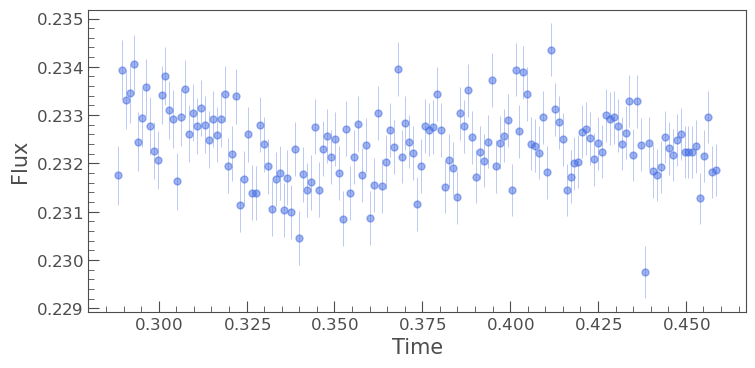

In [18]:
data6 = pandas.read_csv('TOI_237/TIC_305048087_Data5.csv')
flux6 = np.array(data6['rel_flux_T1'])
error6 = np.array(data6['rel_flux_err_T1'])*1.17
times6 = np.array(data6['BJD_TDB'])
airmass6 = np.array(data6['AIRMASS'])
exptime_s6 = np.median(data6['EXPTIME'])
exptime_d6 = exptime_s6 * (1/60) * (1/60) * (1/24)
offset6 = int(times6[0])
times6 = times6-offset6

LC6 = LightCurve(time = times6, flux = flux6, flux_err = error6).remove_outliers(sigma=10)
LC6.errorbar(alpha=0.5,color='royalblue',marker='o',markersize='5',normalize=False)

A6 = np.median(LC6.flux)
B6 = 0.0

LD6 = LD1

n = np.linspace(0,999,1000)
mid_transit_times = (planet_period*n + epoch)-offset6
for i in range(len(n)):
    if (mid_transit_times[i] >= LC6.time[0]):
        if (mid_transit_times[i] <= LC6.time[-1]):
            
            expected_t0_6 = mid_transit_times[i]
            print("Anticipated mid-transit time = {:.6f}".format(expected_t0_6))

In [19]:
# LD1 = [0.2836023,0.3110488] # I

# LD2 = LD1

# LD5 = LD1

# LD6 = LD1

# LD3 = [0.2985298,0.3444681] # g'

# LD4 = [0.5694624,0.3003195] # I+z'

In [20]:
# intialize some walkers
ndim, nwalkers, nsteps = 20, 150, 200000
burnin = int(0.20*nsteps)

# these are initial parameters
A1_init = np.random.uniform(A1-0.005, A1+0.005, nwalkers)
A2_init = np.random.uniform(A2-0.005, A2+0.005, nwalkers)
A3_init = np.random.uniform(A3-0.005, A3+0.005, nwalkers)
A4_init = np.random.uniform(A4-0.005, A4+0.005, nwalkers)
A5_init = np.random.uniform(A5-0.005, A5+0.005, nwalkers)
A6_init = np.random.uniform(A6-0.005, A6+0.005, nwalkers)

B1_init = np.random.uniform(0.00, 0.00003, nwalkers)
B2_init = np.random.uniform(0.00, 0.00003, nwalkers)
B3_init = np.random.uniform(0.00, 0.00003, nwalkers)
B4_init = np.random.uniform(0.00, 0.00003, nwalkers)
B5_init = np.random.uniform(0.00, 0.00003, nwalkers)
B6_init = np.random.uniform(0.00, 0.00003, nwalkers)

t01_init = np.random.uniform(expected_t0_1-0.0005,expected_t0_1+0.0005, nwalkers)
t02_init = np.random.uniform(expected_t0_2-0.0005,expected_t0_2+0.0005, nwalkers)
t03_init = np.random.uniform(expected_t0_3-0.0005,expected_t0_3+0.0005, nwalkers)
t05_init = np.random.uniform(expected_t0_5-0.0005,expected_t0_5+0.0005, nwalkers)
t06_init = np.random.uniform(expected_t0_6-0.0005,expected_t0_6+0.0005, nwalkers)

Rp_init = np.random.uniform(planet_radius-0.01, planet_radius+0.01, nwalkers)
a_init = np.random.uniform(planet_a-0.005, planet_a+0.005, nwalkers)
i_init = np.random.uniform(planet_i-0.005, planet_i+0.005, nwalkers)

p0 = np.transpose([A1_init,A2_init,A3_init,A4_init,A5_init,A6_init,
                   B1_init,B2_init,B3_init,B4_init,B5_init,B6_init,
                   t01_init,t02_init,t03_init,t05_init,t06_init,
                   Rp_init, a_init, i_init])

theta = [A1,A2,A3,A4,A5,A6,B1,B2,B3,B4,B5,B6,
         expected_t0_1,expected_t0_2,expected_t0_3,
         expected_t0_5,expected_t0_6,planet_radius,planet_a,planet_i]

In [21]:
# create a sampler and run it
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                args = (LC1,LC2,LC3,LC4,LC5,LC6,
                                        planet_period,LD1,LD2,LD3,LD4,LD5,LD6,
                                        airmass1,airmass2,airmass3,airmass4,airmass5,airmass6,
                                        planet_a))
result = sampler.run_mcmc(p0, nsteps)

In [22]:
static_params = planet_radius, planet_period, planet_a, planet_i, toi
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
A1_sam,A2_sam,A3_sam,A4_sam,A5_sam,A6_sam,B1_sam,B2_sam,B3_sam,B4_sam,B5_sam,B6_sam,t01_sam,t02_sam,t03_sam,t05_sam,t06_sam,Rp_sam,A_sam,Inc_sam = samples
np.save('TOI237_LCO_samples.dat',samples)

sig1_A1 = np.percentile(A1_sam, [16., 50., 84.])
sig1_A2 = np.percentile(A2_sam, [16., 50., 84.])
sig1_A3 = np.percentile(A3_sam, [16., 50., 84.])
sig1_A4 = np.percentile(A4_sam, [16., 50., 84.])
sig1_A5 = np.percentile(A5_sam, [16., 50., 84.])
sig1_A6 = np.percentile(A6_sam, [16., 50., 84.])

sig1_B1 = np.percentile(B1_sam, [16., 50., 84.])
sig1_B2 = np.percentile(B2_sam, [16., 50., 84.])
sig1_B3 = np.percentile(B3_sam, [16., 50., 84.])
sig1_B4 = np.percentile(B4_sam, [16., 50., 84.])
sig1_B5 = np.percentile(B5_sam, [16., 50., 84.])
sig1_B6 = np.percentile(B6_sam, [16., 50., 84.])

sig1_t01 = np.percentile(t01_sam, [16., 50., 84.])
sig1_t02 = np.percentile(t02_sam, [16., 50., 84.])
sig1_t03 = np.percentile(t03_sam, [16., 50., 84.])
sig1_t05 = np.percentile(t05_sam, [16., 50., 84.])
sig1_t06 = np.percentile(t06_sam, [16., 50., 84.])

sig1_Rp = np.percentile(Rp_sam, [16., 50., 84.])
sig1_A = np.percentile(A_sam, [16., 50., 84.])
sig1_Inc = np.percentile(Inc_sam, [16., 50., 84.])

In [23]:
# for i in range(len(samples)):
#     print(emcee.autocorr.integrated_time(samples[i]))

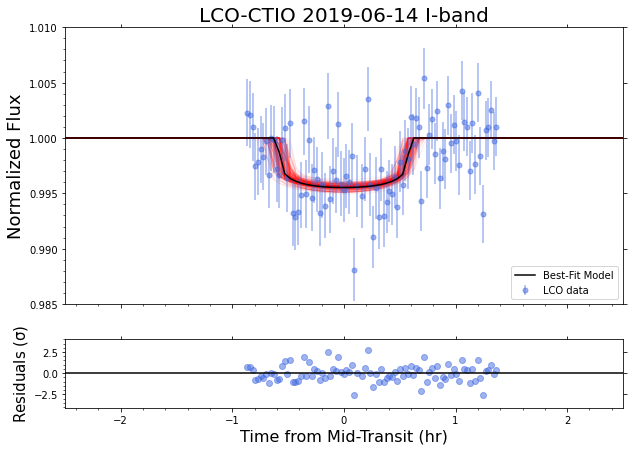

In [24]:
best_parameters = [sig1_A1[1],sig1_B1[1],sig1_Rp[1],sig1_t01[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC1,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='first')

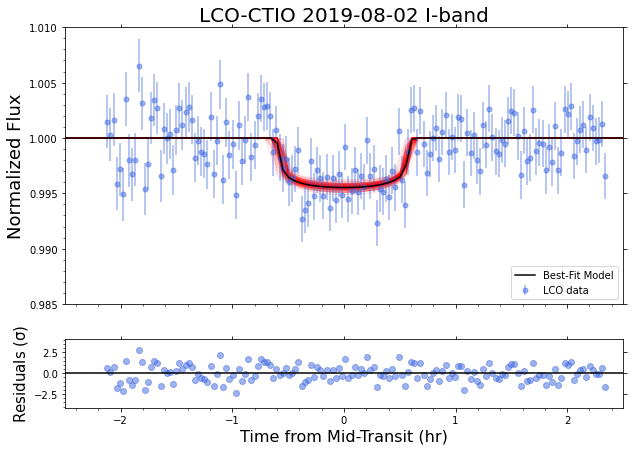

In [25]:
best_parameters = [sig1_A2[1],sig1_B2[1],sig1_Rp[1],sig1_t02[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC2,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='second')

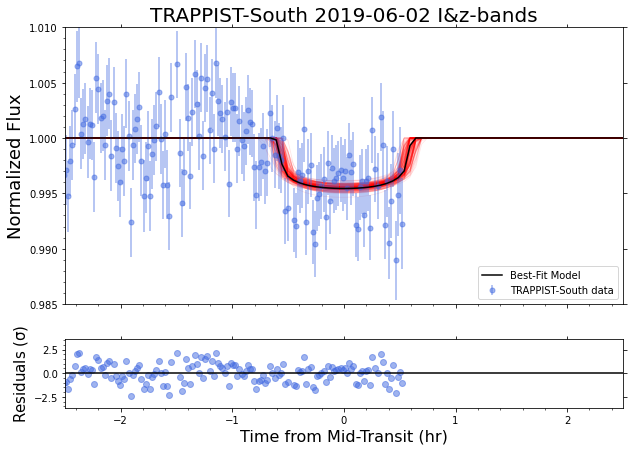

In [26]:
best_parameters = [sig1_A3[1],sig1_B3[1],sig1_Rp[1],sig1_t03[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC3,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='third')

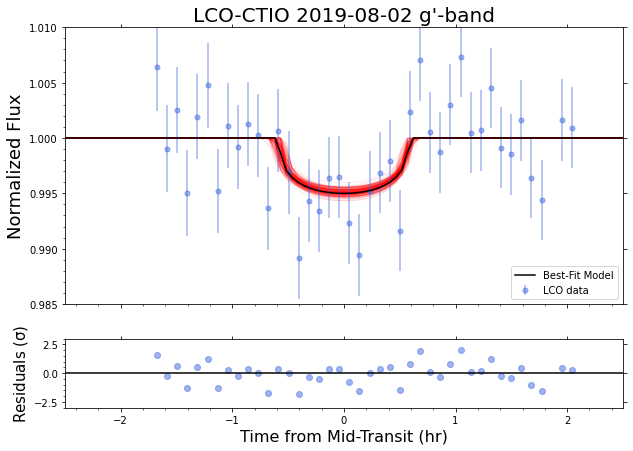

In [27]:
best_parameters = [sig1_A4[1],sig1_B4[1],sig1_Rp[1],sig1_t02[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC4,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='fourth')

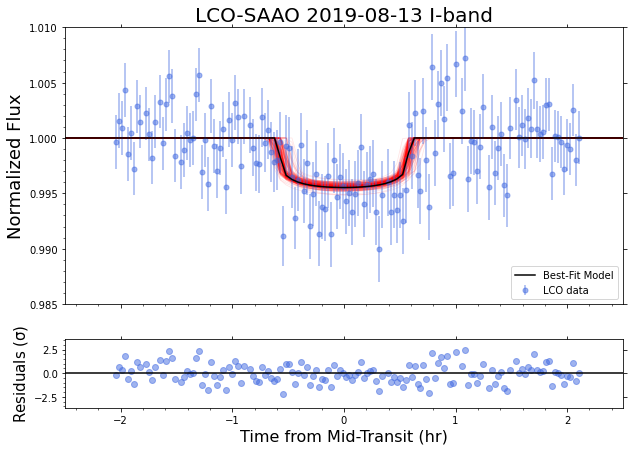

In [28]:
best_parameters = [sig1_A5[1],sig1_B5[1],sig1_Rp[1],sig1_t05[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC5,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='fifth')

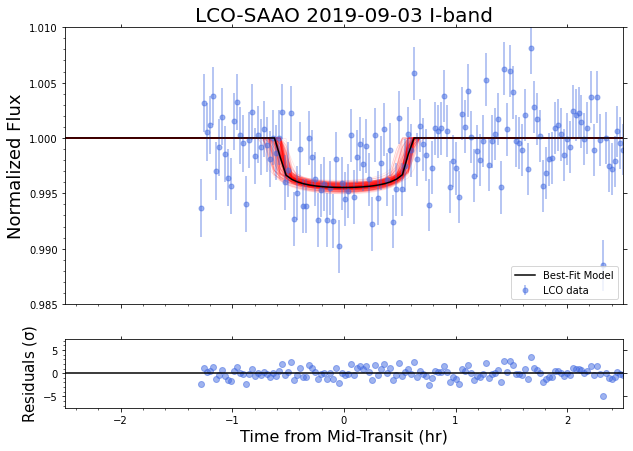

In [29]:
best_parameters = [sig1_A6[1],sig1_B6[1],sig1_Rp[1],sig1_t06[1],sig1_A[1],sig1_Inc[1]]
light_curve(LC6,best_parameters,sampler,static_params,nsteps,epoch,tic_id,obs='sixth')

In [30]:
print('Rp/R* = {:.4f}'.format(sig1_Rp[1]),
      '+ {:.4f}'.format(sig1_Rp[2]-sig1_Rp[1]),
      '- {:.4f}'.format(sig1_Rp[1]-sig1_Rp[0]))

print('a/R* = {:.3f}'.format(sig1_A[1]),
      '+ {:.3f}'.format(sig1_A[2]-sig1_A[1]),
      '- {:.3f}'.format(sig1_A[1]-sig1_A[0]))

print('Inclination (Deg) = {:.3f}'.format(sig1_Inc[1]),
      '+ {:.3f}'.format(sig1_Inc[2]-sig1_Inc[1]),
      '- {:.3f}'.format(sig1_Inc[1]-sig1_Inc[0]))

b_sam = np.cos((Inc_sam)*np.pi/180)*A_sam

sig1_b = np.percentile(b_sam, [16., 50., 84.])

print('Impact parameter (b) = {:.3f}'.format(sig1_b[1]),
      '+ {:.6f}'.format(sig1_b[2]-sig1_b[1]),
      '- {:.6f}'.format(sig1_b[1]-sig1_b[0]))

print('Mid-Transit Time = {:.6f}'.format(offset1+sig1_t01[1]),
      '+ {:.6f}'.format(sig1_t01[2]-sig1_t01[1]),
      '- {:.6f}'.format(sig1_t01[1]-sig1_t01[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset1+expected_t0_1))

print('Mid-Transit Time = {:.6f}'.format(offset2+sig1_t02[1]),
      '+ {:.6f}'.format(sig1_t02[2]-sig1_t02[1]),
      '- {:.6f}'.format(sig1_t02[1]-sig1_t02[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset2+expected_t0_2))

print('Mid-Transit Time = {:.6f}'.format(offset3+sig1_t03[1]),
      '+ {:.6f}'.format(sig1_t03[2]-sig1_t03[1]),
      '- {:.6f}'.format(sig1_t03[1]-sig1_t03[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset3+expected_t0_3))

print('Mid-Transit Time = {:.6f}'.format(offset5+sig1_t05[1]),
      '+ {:.6f}'.format(sig1_t05[2]-sig1_t05[1]),
      '- {:.6f}'.format(sig1_t05[1]-sig1_t05[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset5+expected_t0_5))

print('Mid-Transit Time = {:.6f}'.format(offset6+sig1_t06[1]),
      '+ {:.6f}'.format(sig1_t06[2]-sig1_t06[1]),
      '- {:.6f}'.format(sig1_t06[1]-sig1_t06[0]))
print("Anticipated mid-transit time = {:.6f}".format(offset6+expected_t0_6))

Rp/R* = 0.0625 + 0.0022 - 0.0019
a/R* = 34.279 + 1.870 - 4.596
Inclination (Deg) = 89.502 + 0.351 - 0.594
Impact parameter (b) = 0.300 + 0.267455 - 0.207420
Mid-Transit Time = 2458648.797095 + 0.001820 - 0.001743
Anticipated mid-transit time = 2458648.799102
Mid-Transit Time = 2458697.719834 + 0.000790 - 0.000809
Anticipated mid-transit time = 2458697.723984
Mid-Transit Time = 2458637.922462 + 0.001384 - 0.001321
Anticipated mid-transit time = 2458637.926906
Mid-Transit Time = 2458708.592285 + 0.001518 - 0.001164
Anticipated mid-transit time = 2458708.596180
Mid-Transit Time = 2458730.341916 + 0.001097 - 0.001521
Anticipated mid-transit time = 2458730.340572


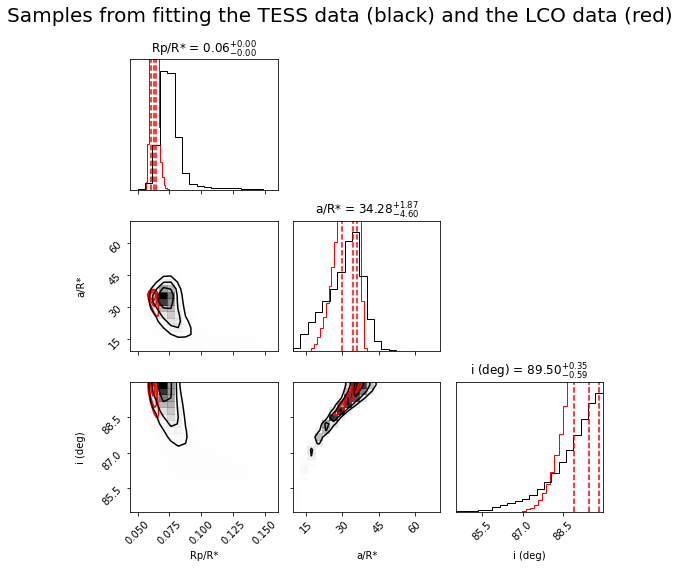

In [31]:
TESS_samples = np.load('TOI_237/TOI237_TESS_samples.dat.npy')
corner(samples,TESS_samples)

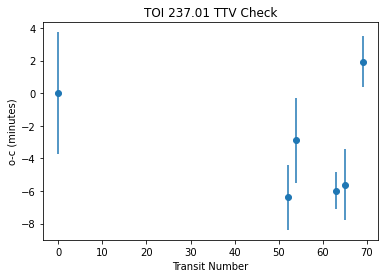

In [32]:
expected = np.array([1355.249810+2457000,
                     expected_t0_1+offset1,
                     expected_t0_2+offset2,
                     expected_t0_3+offset3,
                     expected_t0_5+offset5,
                     expected_t0_6+offset6])
observed = np.array([1355.249810+2457000,
                     sig1_t01[1]+offset1,
                     sig1_t02[1]+offset2,
                     sig1_t03[1]+offset3,
                     sig1_t05[1]+offset5,
                     sig1_t06[1]+offset6])
obs_err = np.array([0.0026,
                    (sig1_t01[2]-sig1_t01[1]),
                    (sig1_t02[2]-sig1_t02[1]),
                    (sig1_t03[2]-sig1_t03[1]),
                    (sig1_t05[2]-sig1_t05[1]),
                    (sig1_t06[2]-sig1_t06[1])])
transit_number = np.array([0,54,63,52,65,69])

diff = (observed-expected)*24.0*60.0
obs_err_plot = obs_err*24.0*60.0

data = Table([transit_number, observed-2457000, obs_err],names=['num','t0','t0_err'])
ascii.write(data,'toi_237_ephem.txt',overwrite=True)

plt.figure()
plt.errorbar(transit_number,diff, yerr=obs_err_plot,fmt='o')
plt.ylabel('o-c (minutes)')
plt.xlabel('Transit Number')
plt.title('TOI {} TTV Check'.format(toi))
plt.savefig('TOI_{:.0f}_TTV.pdf'.format(toi))
plt.show()